In [ ]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [ ]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl
import warnings

warnings.filterwarnings("ignore")

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [ ]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [4]:
# download our example of tabular data: fall_detection.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/fall_detection.csv

File ‘fall_detection.csv’ already there; not retrieving.



I0000 00:00:1740695903.214279  931989 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [5]:
dataset = rf.Dataset.from_csv("fall_detection", "fall_detection.csv")
dataset.to_pandas()

,Age range of patient,Sex,Involvement of medication associated with fall risk,Whether a fall prevention protocol was implemented,Reason for incident,Whether a restraint prescription was given,Whether a physical therapy prescription was given,BBS Score,Body Temperature,Heart Rate,...,Chronic Heart Failure,Stroke,Frozen shoulder,Osteoarthritis of hip,Cerebellar Ataxia,Hemiparesis,GB Syndrome,Fall risk level,Ischemic Heart Disease,Cervical sopondylitis
0,60<70,M,Yes,Yes,Slip,No,Yes,41,97,80,...,No,No,No,No,No,No,No,High,No,No
1,30<40,F,Yes,Yes,Loss of balance,No,No,41,96,78,...,No,No,No,No,No,No,No,High,No,No
2,60<70,M,Yes,Yes,Mental confusion,No,Yes,43,98,81,...,No,No,No,No,No,No,No,High,No,No
3,80<90,M,Yes,Yes,Mental confusion,No,Yes,40,99,82,...,No,No,No,No,No,No,No,High,No,No
4,60<70,M,Yes,Yes,Loss of balance,No,Yes,40,96,90,...,No,No,No,No,No,No,No,High,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,50<60,M,No,No,Muscle weakness,No,No,44,97,67,...,No,No,No,No,No,No,No,Moderate,No,No
2578,80<90,F,No,No,Hypotension,No,No,43,97,96,...,No,No,No,No,No,No,No,Moderate,No,No
2579,30<40,F,No,No,Muscle weakness,No,No,43,96,76,...,No,No,No,No,No,No,No,Moderate,No,No
2580,60<70,M,No,Yes,Loss of balance,No,No,44,99,101,...,No,No,No,No,No,No,No,Moderate,No,No


In [ ]:
categorical_fields = (
    dataset.to_pandas().select_dtypes(include=["object"]).columns
)
continuous_fields = [
    field
    for field in dataset.table.column_names
    if field not in categorical_fields
]
train_config = ra.TrainTabGAN.Config(
    tabular_gan=ra.TrainTabGAN.TrainConfig(epochs=100),
    encoder=ra.TrainTabGAN.DatasetConfig(
        metadata=[
            ra.TrainTabGAN.FieldConfig(field=field, type="continuous")
            for field in continuous_fields
        ]
        + [
            ra.TrainTabGAN.FieldConfig(field=field, type="categorical")
            for field in categorical_fields
        ],
    ),
)
train = ra.TrainTabGAN(train_config)

In [7]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)

print(f"Workflow: {workflow.id()}")

Workflow: 18Er9XxKnABj0mbKMmat4Y


In [8]:
async for log in workflow.logs():
    print(log)

2025-02-27T22:38:50Z dataset-load: INFO Downloading dataset '5TyGkCGJT2MCvYiOfqkqnf'
2025-02-27T22:38:50Z dataset-load: INFO Downloaded dataset '5TyGkCGJT2MCvYiOfqkqnf' with 2582 rows
2025-02-27T22:40:25Z train-tab-gan: INFO Starting training...
2025-02-27T22:40:29Z train-tab-gan: INFO Epoch 1 completed
2025-02-27T22:40:30Z train-tab-gan: INFO Epoch 2 completed
2025-02-27T22:40:31Z train-tab-gan: INFO Epoch 3 completed
2025-02-27T22:40:33Z train-tab-gan: INFO Epoch 4 completed
2025-02-27T22:40:34Z train-tab-gan: INFO Epoch 5 completed
2025-02-27T22:40:35Z train-tab-gan: INFO Epoch 6 completed
2025-02-27T22:40:36Z train-tab-gan: INFO Epoch 7 completed
2025-02-27T22:40:37Z train-tab-gan: INFO Epoch 8 completed
2025-02-27T22:40:38Z train-tab-gan: INFO Epoch 9 completed
2025-02-27T22:40:40Z train-tab-gan: INFO Epoch 10 completed
2025-02-27T22:40:41Z train-tab-gan: INFO Epoch 11 completed
2025-02-27T22:40:42Z train-tab-gan: INFO Epoch 12 completed
2025-02-27T22:40:43Z train-tab-gan: INFO Ep

In [ ]:
model = await workflow.models().nth(0)
model

Model(id='1f25aa7e-f55c-11ef-bf1b-d27724d2d9bb', labels={'workflow_id': '18Er9XxKnABj0mbKMmat4Y'}, create_time=datetime.datetime(2025, 2, 27, 22, 42, 28, tzinfo=datetime.timezone.utc), size_bytes=5748224)

In [ ]:
generate_config = ra.GenerateTabGAN.Config(
    tabular_gan=ra.GenerateTabGAN.GenerateConfig()
)
generate = ra.GenerateTabGAN(generate_config)
save = ra.DatasetSave(name="synthetic")
target = ra.SessionTarget(target=30_000)
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model, target])
builder.add_action(target, parents=[generate])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 502YPyatTXc89sFhWSUAtw


In [20]:
async for log in workflow.logs():
    print(log)

2025-02-27T22:52:39Z generate-tab-gan: INFO Generating 23000 records
2025-02-27T22:52:44Z session-target: INFO new=23000 total=23000 needs=7000
2025-02-27T22:52:44Z dataset-save: INFO Saved dataset '3ib5NuWemrxSAtpf5yeL10' with 23000 rows
2025-02-27T22:52:44Z generate-tab-gan: INFO Generating 23000 records
2025-02-27T22:52:48Z session-target: INFO new=23000 total=46000 needs=-16000


In [21]:
syn = await workflow.datasets().concat(conn)
syn.to_pandas()

,Age range of patient,Sex,Involvement of medication associated with fall risk,Whether a fall prevention protocol was implemented,Reason for incident,Whether a restraint prescription was given,Whether a physical therapy prescription was given,BBS Score,Body Temperature,Heart Rate,...,Chronic Heart Failure,Stroke,Frozen shoulder,Osteoarthritis of hip,Cerebellar Ataxia,Hemiparesis,GB Syndrome,Fall risk level,Ischemic Heart Disease,Cervical sopondylitis
0,50<60,M,Yes,Yes,Slip,No,Yes,37,95,73,...,No,No,No,No,No,No,No,High,No,No
1,60<70,F,Yes,No,Muscle weakness,No,Yes,38,96,107,...,No,No,No,No,No,No,No,High,No,No
2,70<80,M,No,Yes,Mental confusion,No,No,47,95,94,...,No,No,No,No,No,No,No,Low,No,No
3,60<70,M,Yes,No,Mental confusion,No,Yes,41,96,87,...,No,No,No,No,No,No,No,Moderate,No,No
4,70<80,F,Yes,Yes,Loss of balance,No,No,42,97,89,...,No,No,No,No,No,No,No,High,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,70<80,F,Yes,Yes,Muscle weakness,No,No,43,97,92,...,No,No,No,No,No,No,No,Moderate,Yes,No
29996,80<90,F,No,Yes,Muscle weakness,No,Yes,44,97,87,...,No,No,No,No,No,No,No,High,No,No
29997,30<40,M,No,Yes,Muscle weakness,No,Yes,40,96,102,...,No,No,No,No,No,No,No,Moderate,No,Yes
29998,60<70,M,No,Yes,Loss of balance,No,Yes,38,99,74,...,No,No,No,No,No,No,No,High,No,No


### Evaluation


**1. categorical columns**


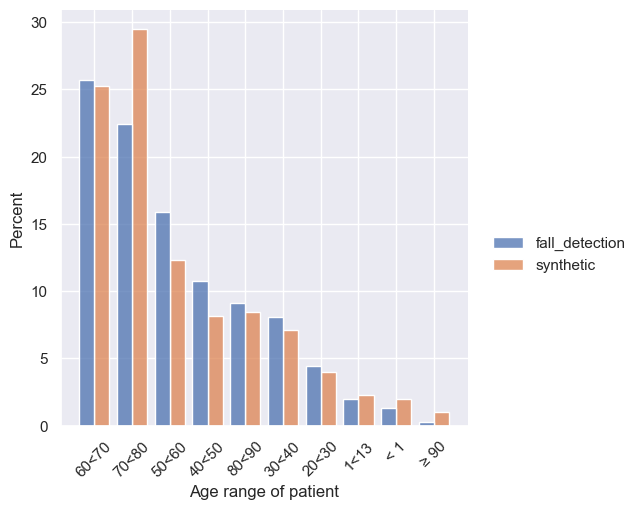

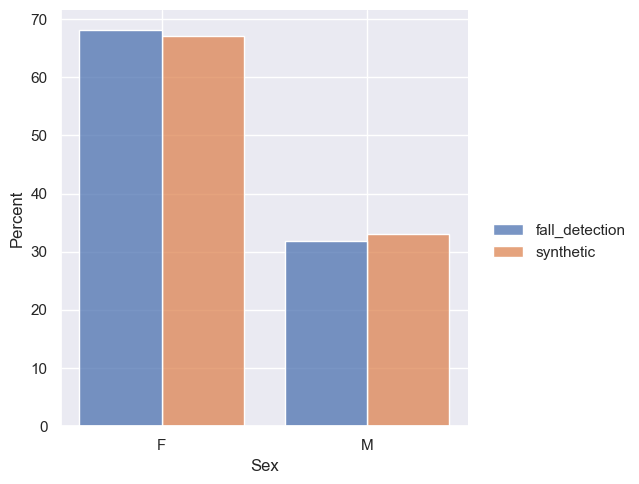

In [22]:
for col in ["Age range of patient", "Sex"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rl.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")

**2. numerical columns**


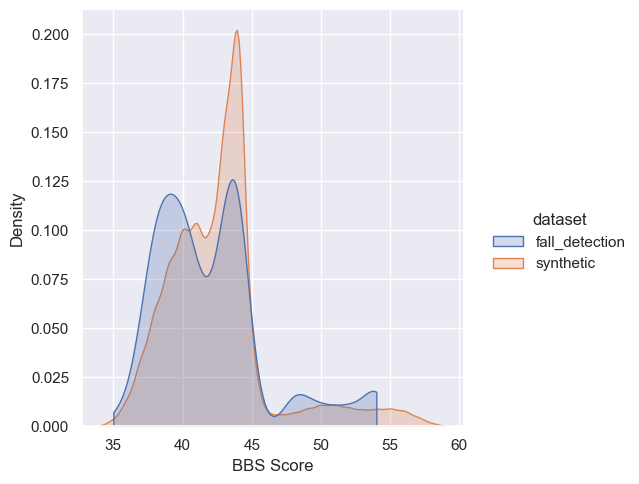

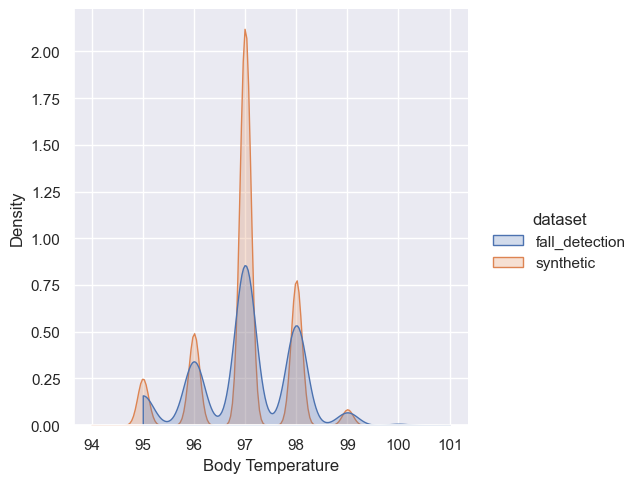

In [14]:
for col in ["BBS Score", "Body Temperature"]:
    rl.vis.plot_kde([dataset, syn], col)

**3. correlation between numerical columns**


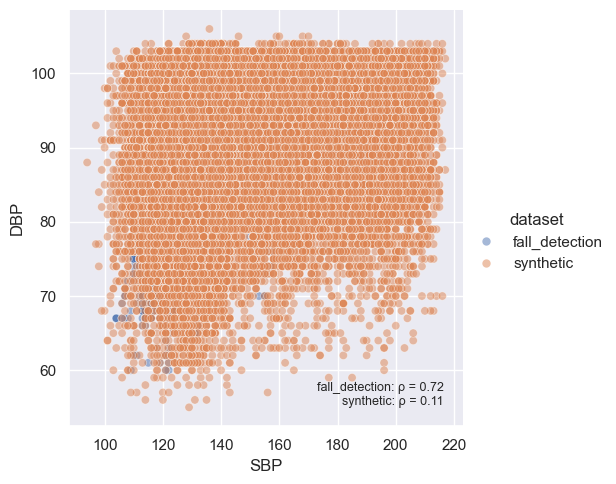

In [15]:
col1 = "SBP"
col2 = "DBP"
rl.vis.plot_correlation([dataset, syn], col1, col2, alpha=0.5)

**4. correlation heatmap between several numerical columns**


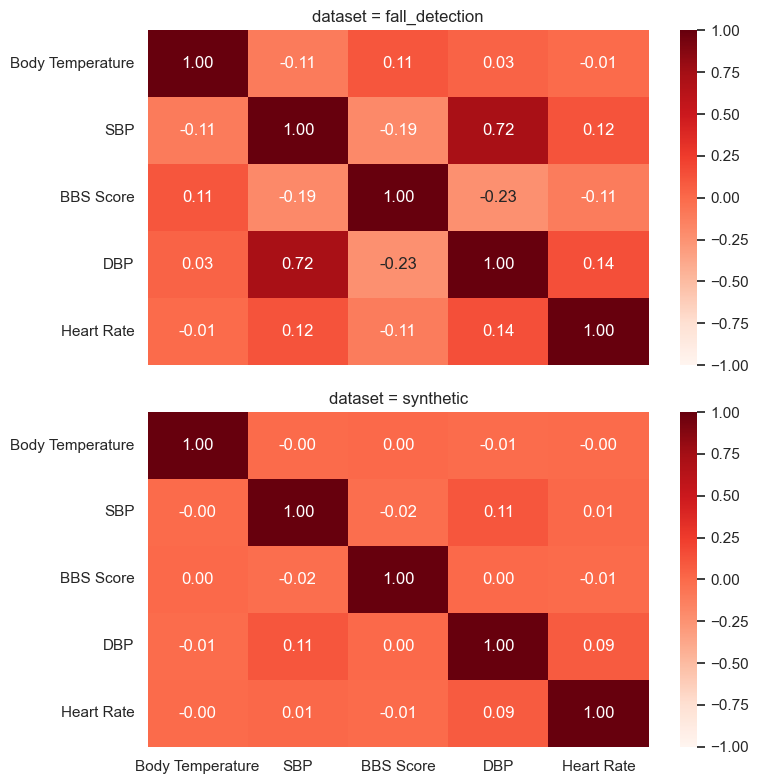

In [16]:
n_cols = ["Body Temperature", "SBP", "BBS Score", "DBP", "Heart Rate"]
rl.vis.plot_correlation_heatmap([dataset, syn], n_cols, annot=True, fmt=".2f")